In [1]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 40.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 40.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 1.0 MB/s eta 0:00:00eta 0:00:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 36.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyprojec

In [2]:
import os
import torch
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from super_gradients.training import dataloaders,models,training_hyperparams,Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import training_hyperparams

[2023-11-04 15:24:35] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-11-04 15:24:35] WARNING - __init__.py - Failed to import pytorch_quantization
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[2023-11-04 15:24:46] INFO - utils.py - NumExpr defaulting to 4 threads.
[2023-11-04 15:24:49] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-04 15:24:49] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-04 15:24:49] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-04 15:24:49] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-11-04 15:24:49] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx required but not found
[2023-11-04 15:24:49] WARNING - env_sanity_check.py - Failed to verify instal

#### Set Reproducibility

In [3]:
os.environ["PYTHONHASHSEED"] = str(1234)
random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

#### Set Constants

In [4]:
data_dir = '/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2'
batch_size = 32

#### Set Data Loader

In [5]:
# Data Transform
train_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Import Data
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Train'), train_transform)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Valid'), test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Test'), test_transform)
# Data Loader
train_dataloader = dataloaders.get(dataset=train_dataset, dataloader_params={
    "num_workers": 2, "batch_size": batch_size, "shuffle": True, "worker_init_fn": seed_worker})
valid_dataloader = dataloaders.get(dataset=valid_dataset, dataloader_params={
    "num_workers": 2, "batch_size": batch_size, "shuffle": False, "worker_init_fn": seed_worker})
test_dataloader = dataloaders.get(dataset=test_dataset, dataloader_params={
    "num_workers": 2, "batch_size": batch_size, "shuffle": False, "worker_init_fn": seed_worker})


## Model 1: Visual Transformer

#### Train Model

In [6]:
# Define Model with Transfer Learning
model_vit = models.get(model_name=Models.VIT_LARGE,
                   num_classes=10,
                   pretrained_weights="imagenet")

# Define Train Params
train_params_vit =  training_hyperparams.get("imagenet_vit_large")
train_params_vit["max_epochs"] = 2
# Training Model
trainer_vit = Trainer("fastfood-clf-train-exp-vit",ckpt_root_dir='/kaggle/working/')
trainer_vit.train(model=model_vit, training_params=train_params_vit,
              train_loader=train_dataloader, valid_loader=valid_dataloader)

Downloading: "https://sghub.deci.ai/models/vit_large_imagenet.pth" to /root/.cache/torch/hub/checkpoints/vit_large_imagenet.pth
100%|██████████| 1.13G/1.13G [01:01<00:00, 19.7MB/s]  
[2023-11-04 15:26:04] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture vit_large
[2023-11-04 15:26:04] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2023-11-04 15:26:10] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231104_152610_445740`
[2023-11-04 15:26:10] INFO - sg_trainer.py - Checkpoints directory: /kaggle/working/fastfood-clf-train-exp-vit/RUN_20231104_152610_445740


The console stream is now moved to /kaggle/working/fastfood-clf-train-exp-vit/RUN_20231104_152610_445740/console_Nov04_15_26_10.txt


[2023-11-04 15:26:11] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            15000      (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         469        (len(train_loader))
    - Gradient updates per epoch:   469        (len(train_loader) / batch_accumulate)

[2023-11-04 15:26:11] INFO - sg_trainer.py - Started training for 2 epochs (0/1)

Train epoch 0:  13%|█▎        | 59/469 [01:55<12:46,  1.87s/it, Accuracy=0.851, LabelSmoothingCrossEntropyLoss=0.556, Top5=0.974, gpu_mem=15.1][2023-11-04 15:26:11] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
   

SUMMARY OF EPOCH 0
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.2853
│   ├── Accuracy = 0.9194
│   └── Top5 = 0.9911
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.3053
    ├── Accuracy = 0.9151
    └── Top5 = 0.9871



Train epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 1: 100%|██████████| 110/110 [01:11<00:00,  1.54it/s]
[2023-11-04 15:58:41] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/fastfood-clf-train-exp-vit/RUN_20231104_152610_445740/ckpt_best.pth
[2023-11-04 15:58:41] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.9259999990463257


SUMMARY OF EPOCH 1
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.152
│   │   ├── Epoch N-1      = 0.2853 (↘ -0.1333)
│   │   └── Best until now = 0.2853 (↘ -0.1333)
│   ├── Accuracy = 0.9575
│   │   ├── Epoch N-1      = 0.9194 (↗ 0.0381)
│   │   └── Best until now = 0.9194 (↗ 0.0381)
│   └── Top5 = 0.9979
│       ├── Epoch N-1      = 0.9911 (↗ 0.0067)
│       └── Best until now = 0.9911 (↗ 0.0067)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.2824
    │   ├── Epoch N-1      = 0.3053 (↘ -0.023)
    │   └── Best until now = 0.3053 (↘ -0.023)
    ├── Accuracy = 0.926
    │   ├── Epoch N-1      = 0.9151 (↗ 0.0109)
    │   └── Best until now = 0.9151 (↗ 0.0109)
    └── Top5 = 0.992
        ├── Epoch N-1      = 0.9871 (↗ 0.0049)
        └── Best until now = 0.9871 (↗ 0.0049)



[2023-11-04 15:59:12] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 2: 100%|██████████| 110/110 [01:11<00:00,  1.55it/s]


#### Evaluate Model

In [7]:
best_model_vit = models.get(model_name=Models.VIT_LARGE,
                   num_classes=10,
                   checkpoint_path=os.path.join(trainer_vit.checkpoints_dir_path,'ckpt_best.pth'))
best_model_vit.eval()

trainer_vit.test(model=best_model_vit, test_loader=test_dataloader)

[2023-11-04 16:00:24] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-11-04 16:00:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working/fastfood-clf-train-exp-vit/RUN_20231104_152610_445740/ckpt_best.pth checkpoint.
Testing:  98%|█████████▊| 46/47 [00:30<00:00,  1.54it/s]

{'LabelSmoothingCrossEntropyLoss': 0.23623852,
 'Accuracy': 0.9346666932106018,
 'Top5': 0.9959999918937683}

#### Individual Testing

Testing: 100%|██████████| 47/47 [00:30<00:00,  1.52it/s]


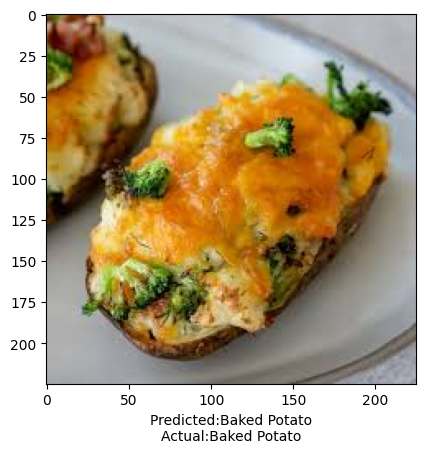

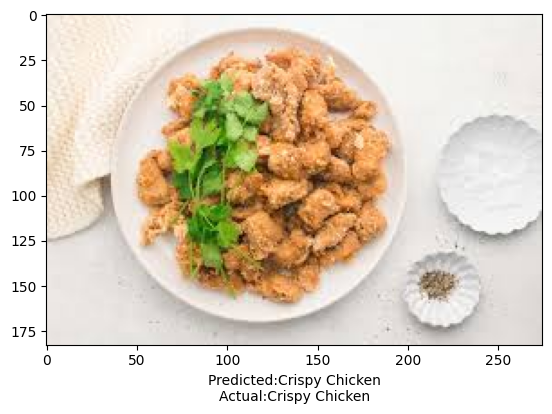

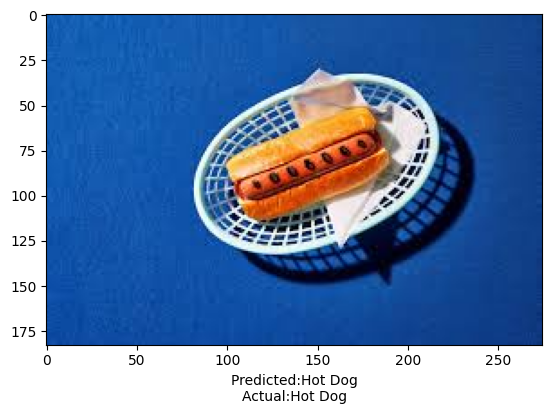

In [8]:
samples_path = [
    ('Baked Potato',os.path.join(data_dir,'Test/Baked Potato/Baked Potato-Test (19).jpeg')),
    ('Crispy Chicken',os.path.join(data_dir,'Test/Crispy Chicken/Crispy Chicken-Test (18).jpeg')),
    ('Hot Dog',os.path.join(data_dir,'Test/Hot Dog/Hot Dog-Test (101).jpeg'))
]
for label,sample_path in samples_path:
    image = Image.open(sample_path)
    input_tensor = test_transform(image).unsqueeze(0).to(next(best_model_vit.parameters()).device)
    predictions = best_model_vit(input_tensor)
    classes = train_dataloader.dataset.classes
    plt.xlabel('Predicted:' + classes[torch.argmax(predictions)] + '\nActual:' + label)
    plt.imshow(image)
    plt.show()

## Model 2: ResNet

#### Train Model

In [9]:
# Define Model with Transfer Learning
model_resnet = models.get(model_name=Models.RESNET50,
                   num_classes=10,
                   pretrained_weights="imagenet")

# Define Train Params
train_params_resnet =  training_hyperparams.get("cifar10_resnet")
train_params_resnet["max_epochs"] = 10
# Training Model
trainer_resnet = Trainer("fastfood-clf-train-exp-resnet",ckpt_root_dir='/kaggle/working/')
trainer_resnet.train(model=model_resnet, training_params=train_params_resnet,
              train_loader=train_dataloader, valid_loader=valid_dataloader)

Downloading: "https://sghub.deci.ai/models/resnet50_imagenet.pth" to /root/.cache/torch/hub/checkpoints/resnet50_imagenet.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.3MB/s]
[2023-11-04 16:01:09] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture resnet50
[2023-11-04 16:01:10] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2023-11-04 16:01:10] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231104_160110_106372`
[2023-11-04 16:01:10] INFO - sg_trainer.py - Checkpoints directory: /kaggle/working/fastfood-clf-train-exp-resnet/RUN_20231104_160110_106372


The console stream is now moved to /kaggle/working/fastfood-clf-train-exp-resnet/RUN_20231104_160110_106372/console_Nov04_16_01_10.txt


[2023-11-04 16:01:11] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            15000      (len(train_set))
    - Batch size per GPU:           32         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             32         (num_gpus * batch_size)
    - Effective Batch size:         32         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         469        (len(train_loader))
    - Gradient updates per epoch:   469        (len(train_loader) / batch_accumulate)

[2023-11-04 16:01:11] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Train epoch 0:  13%|█▎        | 59/469 [00:38<04:22,  1.56it/s, Accuracy=0.435, LabelSmoothingCrossEntropyLoss=1.71, Top5=0.847, gpu_mem=9.76][2023-11-04 16:01:11] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
   

SUMMARY OF EPOCH 0
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.9938
│   ├── Accuracy = 0.6788
│   └── Top5 = 0.9388
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.9364
    ├── Accuracy = 0.7086
    └── Top5 = 0.9477



Train epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 1: 100%|██████████| 110/110 [00:07<00:00, 14.61it/s]
[2023-11-04 16:11:30] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/fastfood-clf-train-exp-resnet/RUN_20231104_160110_106372/ckpt_best.pth
[2023-11-04 16:11:30] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.7702857255935669


SUMMARY OF EPOCH 1
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.5225
│   │   ├── Epoch N-1      = 0.9938 (↘ -0.4713)
│   │   └── Best until now = 0.9938 (↘ -0.4713)
│   ├── Accuracy = 0.8358
│   │   ├── Epoch N-1      = 0.6788 (↗ 0.157)
│   │   └── Best until now = 0.6788 (↗ 0.157)
│   └── Top5 = 0.9837
│       ├── Epoch N-1      = 0.9388 (↗ 0.0449)
│       └── Best until now = 0.9388 (↗ 0.0449)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.722
    │   ├── Epoch N-1      = 0.9364 (↘ -0.2144)
    │   └── Best until now = 0.9364 (↘ -0.2144)
    ├── Accuracy = 0.7703
    │   ├── Epoch N-1      = 0.7086 (↗ 0.0617)
    │   └── Best until now = 0.7086 (↗ 0.0617)
    └── Top5 = 0.974
        ├── Epoch N-1      = 0.9477 (↗ 0.0263)
        └── Best until now = 0.9477 (↗ 0.0263)



Train epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 2: 100%|██████████| 110/110 [00:07<00:00, 14.53it/s]
[2023-11-04 16:16:40] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/fastfood-clf-train-exp-resnet/RUN_20231104_160110_106372/ckpt_best.pth
[2023-11-04 16:16:40] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.7742857336997986


SUMMARY OF EPOCH 2
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.3693
│   │   ├── Epoch N-1      = 0.5225 (↘ -0.1532)
│   │   └── Best until now = 0.5225 (↘ -0.1532)
│   ├── Accuracy = 0.8819
│   │   ├── Epoch N-1      = 0.8358 (↗ 0.0461)
│   │   └── Best until now = 0.8358 (↗ 0.0461)
│   └── Top5 = 0.9905
│       ├── Epoch N-1      = 0.9837 (↗ 0.0067)
│       └── Best until now = 0.9837 (↗ 0.0067)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.7382
    │   ├── Epoch N-1      = 0.722  (↗ 0.0162)
    │   └── Best until now = 0.722  (↗ 0.0162)
    ├── Accuracy = 0.7743
    │   ├── Epoch N-1      = 0.7703 (↗ 0.004)
    │   └── Best until now = 0.7703 (↗ 0.004)
    └── Top5 = 0.9717
        ├── Epoch N-1      = 0.974  (↘ -0.0023)
        └── Best until now = 0.974  (↘ -0.0023)



Train epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 3: 100%|██████████| 110/110 [00:07<00:00, 14.39it/s]
[2023-11-04 16:21:50] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/fastfood-clf-train-exp-resnet/RUN_20231104_160110_106372/ckpt_best.pth
[2023-11-04 16:21:50] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8122857213020325


SUMMARY OF EPOCH 3
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.2973
│   │   ├── Epoch N-1      = 0.3693 (↘ -0.072)
│   │   └── Best until now = 0.3693 (↘ -0.072)
│   ├── Accuracy = 0.9056
│   │   ├── Epoch N-1      = 0.8819 (↗ 0.0237)
│   │   └── Best until now = 0.8819 (↗ 0.0237)
│   └── Top5 = 0.9946
│       ├── Epoch N-1      = 0.9905 (↗ 0.0041)
│       └── Best until now = 0.9905 (↗ 0.0041)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.6204
    │   ├── Epoch N-1      = 0.7382 (↘ -0.1178)
    │   └── Best until now = 0.722  (↘ -0.1016)
    ├── Accuracy = 0.8123
    │   ├── Epoch N-1      = 0.7743 (↗ 0.038)
    │   └── Best until now = 0.7743 (↗ 0.038)
    └── Top5 = 0.9757
        ├── Epoch N-1      = 0.9717 (↗ 0.004)
        └── Best until now = 0.974  (↗ 0.0017)



Train epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 4: 100%|██████████| 110/110 [00:07<00:00, 14.79it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.2354
│   │   ├── Epoch N-1      = 0.2973 (↘ -0.0619)
│   │   └── Best until now = 0.2973 (↘ -0.0619)
│   ├── Accuracy = 0.9238
│   │   ├── Epoch N-1      = 0.9056 (↗ 0.0182)
│   │   └── Best until now = 0.9056 (↗ 0.0182)
│   └── Top5 = 0.9965
│       ├── Epoch N-1      = 0.9946 (↗ 0.0019)
│       └── Best until now = 0.9946 (↗ 0.0019)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.7001
    │   ├── Epoch N-1      = 0.6204 (↗ 0.0797)
    │   └── Best until now = 0.6204 (↗ 0.0797)
    ├── Accuracy = 0.7963
    │   ├── Epoch N-1      = 0.8123 (↘ -0.016)
    │   └── Best until now = 0.8123 (↘ -0.016)
    └── Top5 = 0.9731
        ├── Epoch N-1      = 0.9757 (↘ -0.0026)
        └── Best until now = 0.9757 (↘ -0.0026)



Train epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 5: 100%|██████████| 110/110 [00:07<00:00, 14.38it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.2029
│   │   ├── Epoch N-1      = 0.2354 (↘ -0.0325)
│   │   └── Best until now = 0.2354 (↘ -0.0325)
│   ├── Accuracy = 0.9345
│   │   ├── Epoch N-1      = 0.9238 (↗ 0.0107)
│   │   └── Best until now = 0.9238 (↗ 0.0107)
│   └── Top5 = 0.9984
│       ├── Epoch N-1      = 0.9965 (↗ 0.0019)
│       └── Best until now = 0.9965 (↗ 0.0019)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.7496
    │   ├── Epoch N-1      = 0.7001 (↗ 0.0495)
    │   └── Best until now = 0.6204 (↗ 0.1292)
    ├── Accuracy = 0.8014
    │   ├── Epoch N-1      = 0.7963 (↗ 0.0051)
    │   └── Best until now = 0.8123 (↘ -0.0109)
    └── Top5 = 0.9734
        ├── Epoch N-1      = 0.9731 (↗ 0.0003)
        └── Best until now = 0.9757 (↘ -0.0023)



Train epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 6: 100%|██████████| 110/110 [00:07<00:00, 14.18it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.18
│   │   ├── Epoch N-1      = 0.2029 (↘ -0.0229)
│   │   └── Best until now = 0.2029 (↘ -0.0229)
│   ├── Accuracy = 0.9417
│   │   ├── Epoch N-1      = 0.9345 (↗ 0.0071)
│   │   └── Best until now = 0.9345 (↗ 0.0071)
│   └── Top5 = 0.9986
│       ├── Epoch N-1      = 0.9984 (↗ 0.0002)
│       └── Best until now = 0.9984 (↗ 0.0002)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.7514
    │   ├── Epoch N-1      = 0.7496 (↗ 0.0018)
    │   └── Best until now = 0.6204 (↗ 0.131)
    ├── Accuracy = 0.7909
    │   ├── Epoch N-1      = 0.8014 (↘ -0.0106)
    │   └── Best until now = 0.8123 (↘ -0.0214)
    └── Top5 = 0.9734
        ├── Epoch N-1      = 0.9734 (= 0.0)
        └── Best until now = 0.9757 (↘ -0.0023)



Train epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 7: 100%|██████████| 110/110 [00:07<00:00, 14.67it/s]
[2023-11-04 16:42:33] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/fastfood-clf-train-exp-resnet/RUN_20231104_160110_106372/ckpt_best.pth
[2023-11-04 16:42:33] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8162857294082642


SUMMARY OF EPOCH 7
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.1556
│   │   ├── Epoch N-1      = 0.18   (↘ -0.0244)
│   │   └── Best until now = 0.18   (↘ -0.0244)
│   ├── Accuracy = 0.9497
│   │   ├── Epoch N-1      = 0.9417 (↗ 0.0081)
│   │   └── Best until now = 0.9417 (↗ 0.0081)
│   └── Top5 = 0.9988
│       ├── Epoch N-1      = 0.9986 (↗ 0.0002)
│       └── Best until now = 0.9986 (↗ 0.0002)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.6675
    │   ├── Epoch N-1      = 0.7514 (↘ -0.0839)
    │   └── Best until now = 0.6204 (↗ 0.0471)
    ├── Accuracy = 0.8163
    │   ├── Epoch N-1      = 0.7909 (↗ 0.0254)
    │   └── Best until now = 0.8123 (↗ 0.004)
    └── Top5 = 0.9771
        ├── Epoch N-1      = 0.9734 (↗ 0.0037)
        └── Best until now = 0.9757 (↗ 0.0014)



Train epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 8: 100%|██████████| 110/110 [00:07<00:00, 14.12it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.1399
│   │   ├── Epoch N-1      = 0.1556 (↘ -0.0157)
│   │   └── Best until now = 0.1556 (↘ -0.0157)
│   ├── Accuracy = 0.9536
│   │   ├── Epoch N-1      = 0.9497 (↗ 0.0039)
│   │   └── Best until now = 0.9497 (↗ 0.0039)
│   └── Top5 = 0.9992
│       ├── Epoch N-1      = 0.9988 (↗ 0.0004)
│       └── Best until now = 0.9988 (↗ 0.0004)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.7644
    │   ├── Epoch N-1      = 0.6675 (↗ 0.0969)
    │   └── Best until now = 0.6204 (↗ 0.144)
    ├── Accuracy = 0.8157
    │   ├── Epoch N-1      = 0.8163 (↘ -0.0006)
    │   └── Best until now = 0.8163 (↘ -0.0006)
    └── Top5 = 0.9774
        ├── Epoch N-1      = 0.9771 (↗ 0.0003)
        └── Best until now = 0.9771 (↗ 0.0003)



Train epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validating epoch 9: 100%|██████████| 110/110 [00:07<00:00, 14.36it/s]
[2023-11-04 16:52:57] INFO - base_sg_logger.py - Checkpoint saved in /kaggle/working/fastfood-clf-train-exp-resnet/RUN_20231104_160110_106372/ckpt_best.pth
[2023-11-04 16:52:57] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.8180000185966492


SUMMARY OF EPOCH 9
├── Train
│   ├── Labelsmoothingcrossentropyloss = 0.1461
│   │   ├── Epoch N-1      = 0.1399 (↗ 0.0062)
│   │   └── Best until now = 0.1399 (↗ 0.0062)
│   ├── Accuracy = 0.9527
│   │   ├── Epoch N-1      = 0.9536 (↘ -0.0009)
│   │   └── Best until now = 0.9536 (↘ -0.0009)
│   └── Top5 = 0.9993
│       ├── Epoch N-1      = 0.9992 (↗ 0.0001)
│       └── Best until now = 0.9992 (↗ 0.0001)
└── Validation
    ├── Labelsmoothingcrossentropyloss = 0.68
    │   ├── Epoch N-1      = 0.7644 (↘ -0.0844)
    │   └── Best until now = 0.6204 (↗ 0.0596)
    ├── Accuracy = 0.818
    │   ├── Epoch N-1      = 0.8157 (↗ 0.0023)
    │   └── Best until now = 0.8163 (↗ 0.0017)
    └── Top5 = 0.9766
        ├── Epoch N-1      = 0.9774 (↘ -0.0009)
        └── Best until now = 0.9774 (↘ -0.0009)



[2023-11-04 16:53:00] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 110/110 [00:07<00:00, 14.49it/s]


#### Evaluate Model

In [10]:
best_model_resnet = models.get(model_name=Models.RESNET50,num_classes=10,
                   checkpoint_path=os.path.join(trainer_resnet.checkpoints_dir_path,'ckpt_best.pth'))

best_model_resnet.eval()

trainer_resnet.test(model=best_model_resnet, test_loader=test_dataloader)

[2023-11-04 16:53:08] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-11-04 16:53:08] INFO - checkpoint_utils.py - Successfully loaded model weights from /kaggle/working/fastfood-clf-train-exp-resnet/RUN_20231104_160110_106372/ckpt_best.pth checkpoint.
Testing:  96%|█████████▌| 45/47 [00:04<00:00, 14.18it/s]

{'LabelSmoothingCrossEntropyLoss': 0.6477131,
 'Accuracy': 0.8213333487510681,
 'Top5': 0.9793333411216736}

#### Individual Testing

Testing: 100%|██████████| 47/47 [00:04<00:00, 10.33it/s]


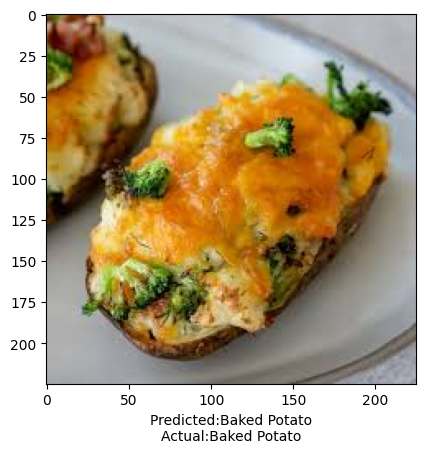

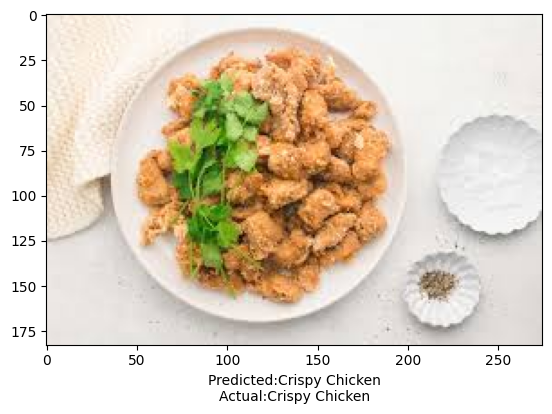

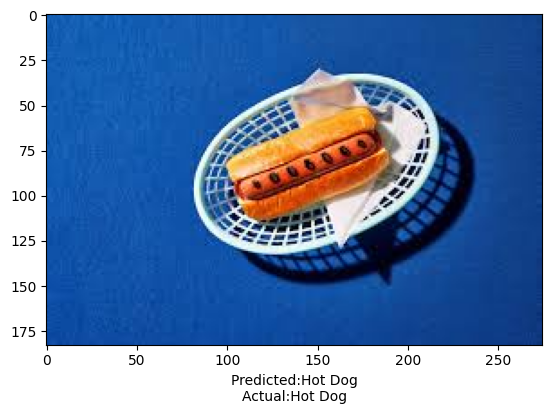

In [11]:
samples_path = [
    ('Baked Potato',os.path.join(data_dir,'Test/Baked Potato/Baked Potato-Test (19).jpeg')),
    ('Crispy Chicken',os.path.join(data_dir,'Test/Crispy Chicken/Crispy Chicken-Test (18).jpeg')),
    ('Hot Dog',os.path.join(data_dir,'Test/Hot Dog/Hot Dog-Test (101).jpeg'))
]
for label,sample_path in samples_path:
    image = Image.open(sample_path)
    input_tensor = test_transform(image).unsqueeze(0).to(next(best_model_resnet.parameters()).device)
    predictions = best_model_resnet(input_tensor)
    classes = train_dataloader.dataset.classes
    plt.xlabel('Predicted:' + classes[torch.argmax(predictions)] + '\nActual:' + label)
    plt.imshow(image)
    plt.show()